In [4]:
!pip install lifelines
!pip install 'ray[default]'
!pip install 'ray[tune]'

# PyTorch Geometric (Colab-friendly)
!pip install torch_geometric torch_scatter



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
  Using cached torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
  Using cached xxhash-3.6.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
Using cached torch_geometric-2.7.0-py3-none-any.whl (1.3 MB)
Using cached xxhash-3.6.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (193 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torch_geometric] [torch_geometric]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
import os
import pandas as pd
import numpy as np
import pickle
import time
from tqdm import tqdm

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

use_cuda = torch.cuda.is_available()

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv


In [9]:
data = pd.read_csv('thyroid_data.csv')

drop_cols = [
    'S.no','On Thyroxine','Query on Thyroxine','On Antithyroid Medication',
    'I131 Treatment','Query Hypothyroid','Query Hyperthyroid','Lithium',
    'TSH Measured','Hypopituitary','Psych','T3 Measured','TT4 Measured',
    'T4U Measured','FTI Measured'
]
data = data.drop(drop_cols, axis=1)

# Fix missing lab values
for col in ['Age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    data[col] = data[col].replace('?', np.nan).astype(float)
    data[col].fillna(data[col].median(), inplace=True)

data['Sex'].fillna(data['Sex'].mode()[0], inplace=True)

# One-hot encoding
cats = ['Sex','Sick','Pregnant','Thyroid Surgery','Goitre','Tumor']
for c in cats:
    d = pd.get_dummies(data[c], drop_first=True, prefix=c)
    data = pd.concat([data, d], axis=1)
data = data.drop(cats, axis=1)

# map classes
label_map = {'negative':0,'hyperthyroid':1,'hypothyroid':2,'sick':3}
data['Prescription'] = data['Category'].map(label_map)
data = data.drop('Category', axis=1)


In [10]:
# oversample
balanced = []
max_count = data['Prescription'].value_counts().max()
for c in data['Prescription'].unique():
    df_c = data[data['Prescription']==c]
    if len(df_c) < max_count:
        df_c = resample(df_c, replace=True, n_samples=max_count, random_state=0)
    balanced.append(df_c)

data_bal = pd.concat(balanced).reset_index(drop=True)

# scale
scaler = StandardScaler()
X = scaler.fit_transform(data_bal.drop('Prescription', axis=1))
y = data_bal['Prescription'].values

df_scaled = pd.DataFrame(X, columns=data_bal.drop('Prescription', axis=1).columns)
df_scaled['Prescription'] = y


In [30]:
train_df, test_df = train_test_split(df_scaled, test_size=0.2, random_state=0)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=0)

def df_to_tensors(df):
    X = df.drop('Prescription', axis=1).values.astype(np.float32)
    y = df['Prescription'].values.astype(np.int64)
    X = torch.tensor(X).unsqueeze(1)     # [batch, seq_len=1, features]
    y = torch.tensor(y)
    return X, y

train_X, train_y = df_to_tensors(train_df)
valid_X, valid_y = df_to_tensors(valid_df)
test_X,  test_y  = df_to_tensors(test_df)

# --- Build graphs for each split ---
train_edge_index = build_similarity_graph(train_X)
valid_edge_index = build_similarity_graph(valid_X)
test_edge_index  = build_similarity_graph(test_X)

train_graph = Data(x=train_X.squeeze(1), edge_index=train_edge_index)
valid_graph = Data(x=valid_X.squeeze(1), edge_index=valid_edge_index)
test_graph  = Data(x=test_X.squeeze(1),  edge_index=test_edge_index)

if use_cuda:
    train_graph = train_graph.to('cuda')
    valid_graph = valid_graph.to('cuda')
    test_graph  = test_graph.to('cuda')



In [31]:
def build_similarity_graph(features, threshold=0.7):
    feats = features.squeeze(1)
    norm = feats / feats.norm(dim=1, keepdim=True)
    sim = torch.mm(norm, norm.T)
    edge_index = (sim > threshold).nonzero().T   # [2, E]
    return edge_index

edge_index = build_similarity_graph(train_X)
gnn_data = Data(x=train_X.squeeze(1), edge_index=edge_index)
if use_cuda:
    gnn_data = gnn_data.to('cuda')


In [46]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Normalize graph features
# -----------------------------
scaler_graph = StandardScaler()
train_graph_x = scaler_graph.fit_transform(train_graph.x.cpu())
valid_graph_x = scaler_graph.transform(valid_graph.x.cpu())
test_graph_x  = scaler_graph.transform(test_graph.x.cpu())

train_graph.x = torch.tensor(train_graph_x, dtype=torch.float32)
valid_graph.x = torch.tensor(valid_graph_x, dtype=torch.float32)
test_graph.x  = torch.tensor(test_graph_x,  dtype=torch.float32)

if use_cuda:
    train_graph.x = train_graph.x.cuda()
    valid_graph.x = valid_graph.x.cuda()
    test_graph.x  = test_graph.x.cuda()

# -----------------------------
# Compute class weights for imbalance
# -----------------------------
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_y.cpu().numpy()),
    y=train_y.cpu().numpy()
)
weights = torch.tensor(class_weights, dtype=torch.float32)
if use_cuda:
    weights = weights.cuda()

# Option 1: Weighted CrossEntropyLoss with optional label smoothing
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

# -----------------------------
# Model with dropout in fusion layer
# -----------------------------
class GRU_GNN(nn.Module):
    def __init__(self, input_size, hidden_size, gnn_hidden, num_classes):
        super().__init__()
        
        # GRU encoder
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)

        # GNN encoder
        self.gnn1 = GCNConv(input_size, gnn_hidden)
        self.gnn2 = GCNConv(gnn_hidden, hidden_size)

        # fusion classifier
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(0.3)  # Dropout in fusion layer

    def forward(self, x, gnn_x, edge_index):
        # GRU branch
        gru_out, _ = self.gru(x)
        gru_feat = gru_out[:, -1, :]

        # GNN branch
        g = F.relu(self.gnn1(gnn_x, edge_index))
        g = F.dropout(g, p=0.3, training=self.training)
        g = self.gnn2(g, edge_index)

        batch_size = x.shape[0]
        g_batch = g[:batch_size]

        fusion = torch.cat([gru_feat, g_batch], dim=1)
        fusion = self.dropout(fusion)

        return self.fc(fusion)

# -----------------------------
# Initialize model, optimizer, scheduler
# -----------------------------
model = GRU_GNN(input_size, hidden_size, gnn_hidden, num_classes)
if use_cuda:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Learning rate scheduler (validation-based)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6
)


In [47]:
input_size = train_X.shape[2]
hidden_size = 32
gnn_hidden = 32
num_classes = 4

model = GRU_GNN(input_size, hidden_size, gnn_hidden, num_classes)
if use_cuda:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


In [49]:
# -----------------------------
# Initialize tracking lists
# -----------------------------
train_losses = []
val_losses = []
train_accs = []
val_accs = []

epochs = 100
patience = 10
best_loss = float('inf')
counter = 0

for epoch in range(epochs):

    # -----------------------------
    # TRAINING
    # -----------------------------
    model.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    
    optimizer.zero_grad()

    outputs = model(
        train_X.cuda() if use_cuda else train_X,
        train_graph.x,
        train_graph.edge_index
    )

    loss = criterion(outputs, train_y.cuda() if use_cuda else train_y)
    loss.backward()
    optimizer.step()

    # Loss tracking
    epoch_loss = loss.item()

    # Accuracy tracking
    preds = outputs.argmax(dim=1)
    epoch_correct = (preds == (train_y.cuda() if use_cuda else train_y)).sum().item()
    epoch_total = train_y.size(0)

    train_losses.append(epoch_loss)
    train_accs.append(epoch_correct / epoch_total)

    # -----------------------------
    # VALIDATION
    # -----------------------------
    model.eval()
    with torch.no_grad():
        val_outputs = model(
            valid_X.cuda() if use_cuda else valid_X,
            valid_graph.x,
            valid_graph.edge_index
        )
        val_loss = criterion(val_outputs, valid_y.cuda() if use_cuda else valid_y)


    # Validation loss tracking
    val_losses.append(val_loss.item())

    # Validation accuracy
    val_preds = val_outputs.argmax(dim=1)
    val_correct = (val_preds == (valid_y.cuda() if use_cuda else valid_y)).sum().item()
    val_accs.append(val_correct / valid_y.size(0))

    scheduler.step(val_loss)

    # -----------------------------
    # LOGGING
    # -----------------------------
    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss={train_losses[-1]:.4f} | "
          f"Val Loss={val_losses[-1]:.4f} | "
          f"Train Acc={train_accs[-1]:.3f} | "
          f"Val Acc={val_accs[-1]:.3f}")

    # -----------------------------
    # EARLY STOPPING
    # -----------------------------
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_gru_gnn.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break


Epoch 001 | Train Loss=0.8221 | Val Loss=0.7395 | Train Acc=0.665 | Val Acc=0.708
Epoch 002 | Train Loss=0.8078 | Val Loss=0.7289 | Train Acc=0.675 | Val Acc=0.715
Epoch 003 | Train Loss=0.7994 | Val Loss=0.7200 | Train Acc=0.677 | Val Acc=0.707
Epoch 004 | Train Loss=0.7906 | Val Loss=0.7132 | Train Acc=0.678 | Val Acc=0.707
Epoch 005 | Train Loss=0.7836 | Val Loss=0.7091 | Train Acc=0.677 | Val Acc=0.702
Epoch 006 | Train Loss=0.7758 | Val Loss=0.7067 | Train Acc=0.688 | Val Acc=0.714
Epoch 007 | Train Loss=0.7670 | Val Loss=0.7041 | Train Acc=0.695 | Val Acc=0.710
Epoch 008 | Train Loss=0.7631 | Val Loss=0.6991 | Train Acc=0.701 | Val Acc=0.712
Epoch 009 | Train Loss=0.7549 | Val Loss=0.6925 | Train Acc=0.701 | Val Acc=0.718
Epoch 010 | Train Loss=0.7484 | Val Loss=0.6857 | Train Acc=0.706 | Val Acc=0.716
Epoch 011 | Train Loss=0.7448 | Val Loss=0.6789 | Train Acc=0.709 | Val Acc=0.719
Epoch 012 | Train Loss=0.7359 | Val Loss=0.6727 | Train Acc=0.714 | Val Acc=0.725
Epoch 013 | Trai

In [50]:
model.load_state_dict(torch.load("best_gru_gnn.pth"))
model.eval()

with torch.no_grad():
    preds = model(
        test_X.cuda() if use_cuda else test_X,
        test_graph.x,
        test_graph.edge_index
    )
    _, predicted = torch.max(preds, 1)
    print(classification_report(test_y.numpy(), predicted.cpu().numpy()))


              precision    recall  f1-score   support

           0       0.93      0.76      0.84       300
           1       0.86      0.99      0.92       258
           2       0.84      0.85      0.85       262
           3       0.80      0.84      0.82       282

    accuracy                           0.86      1102
   macro avg       0.86      0.86      0.86      1102
weighted avg       0.86      0.86      0.85      1102



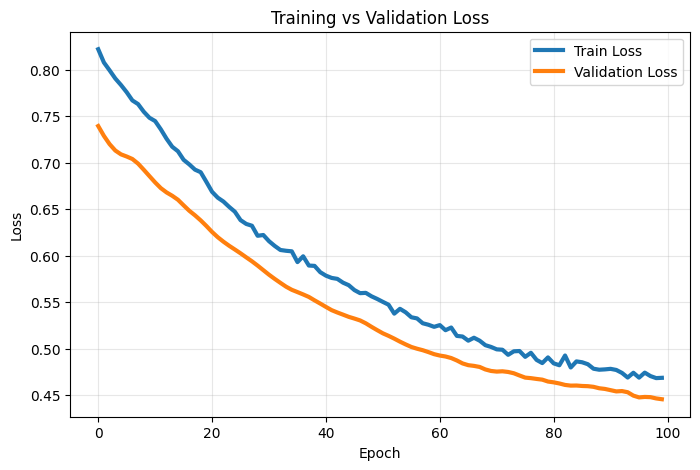

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', linewidth=3)
plt.plot(val_losses, label='Validation Loss', linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       300
           1       0.86      0.99      0.92       258
           2       0.84      0.85      0.85       262
           3       0.80      0.84      0.82       282

    accuracy                           0.86      1102
   macro avg       0.86      0.86      0.86      1102
weighted avg       0.86      0.86      0.85      1102



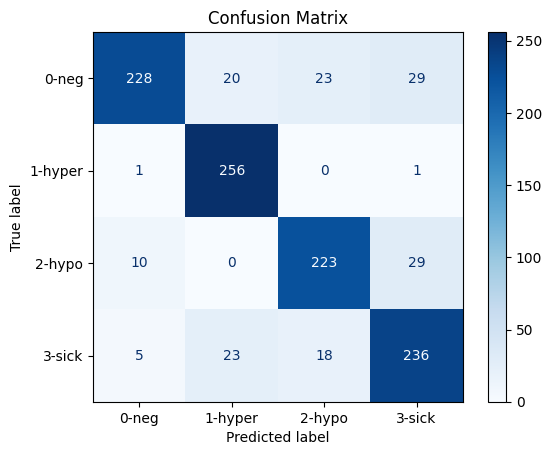

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model.eval()
with torch.no_grad():
    test_outputs = model(
        test_X.cuda() if use_cuda else test_X,
        test_graph.x,
        test_graph.edge_index
    )
    _, test_preds = torch.max(test_outputs, 1)
    y_true = test_y.cpu().numpy()
    y_pred = test_preds.cpu().numpy()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0-neg','1-hyper','2-hypo','3-sick'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


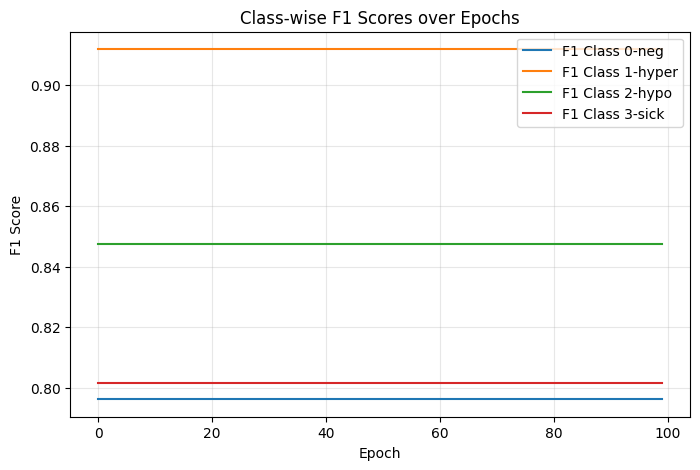

In [53]:
from sklearn.metrics import f1_score

val_f1s = []

for epoch in range(epochs):
    # ... your training and validation code ...
    
    val_preds = val_outputs.argmax(dim=1)
    val_f1 = f1_score(
        valid_y.cpu().numpy(),
        val_preds.cpu().numpy(),
        average=None  # returns array for each class
    )
    val_f1s.append(val_f1)

# Convert to array for plotting
val_f1s = np.array(val_f1s)

plt.figure(figsize=(8,5))
for i, cls in enumerate(['0-neg','1-hyper','2-hypo','3-sick']):
    plt.plot(val_f1s[:, i], label=f'F1 Class {cls}')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Scores over Epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


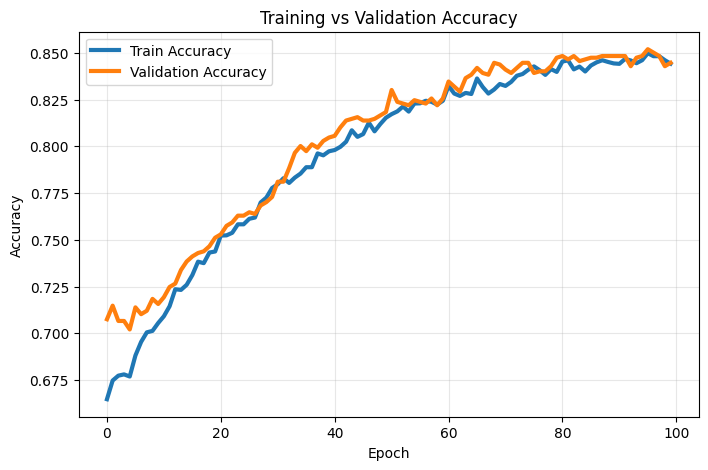

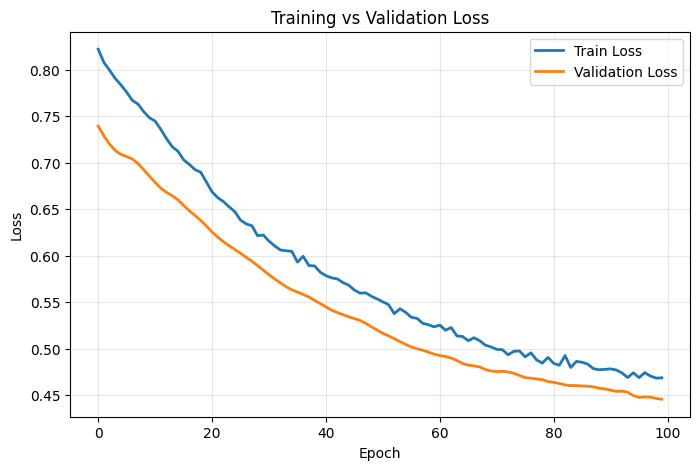

In [54]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Train Accuracy', linewidth=3)
plt.plot(val_accs, label='Validation Accuracy', linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Loss (already plotted, but can combine with accuracy)
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [65]:
model.eval()
with torch.no_grad():
    out = model(test_X, test_graph.x, test_graph.edge_index)
    preds = out.argmax(dim=1)

for idx in np.random.choice(len(test_X), 10, replace=False):
    print(f"Sample {idx} | True: {test_y[idx].item()} | Predicted: {preds[idx].item()}")


Sample 681 | True: 0 | Predicted: 0
Sample 616 | True: 3 | Predicted: 3
Sample 453 | True: 2 | Predicted: 3
Sample 851 | True: 3 | Predicted: 3
Sample 31 | True: 1 | Predicted: 1
Sample 715 | True: 0 | Predicted: 0
Sample 619 | True: 2 | Predicted: 2
Sample 719 | True: 2 | Predicted: 2
Sample 530 | True: 0 | Predicted: 0
Sample 2 | True: 0 | Predicted: 0


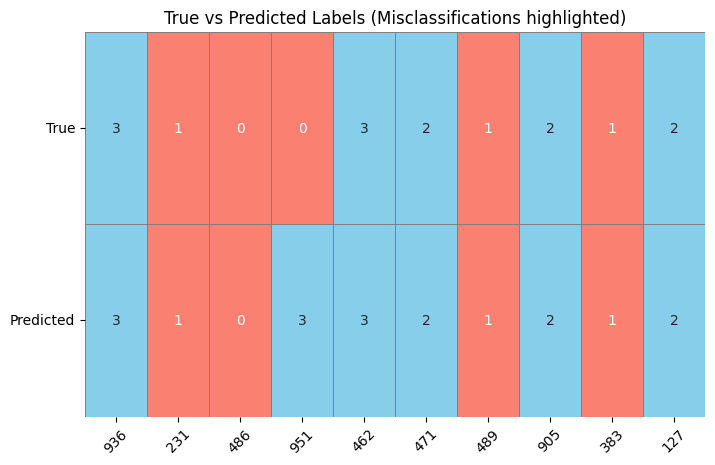

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Evaluate model
model.eval()
with torch.no_grad():
    out = model(test_X, test_graph.x, test_graph.edge_index)
    preds = out.argmax(dim=1)

# Randomly pick 10 test samples
num_samples = 10
indices = np.random.choice(len(test_X), num_samples, replace=False)

# Create DataFrame
df_samples = pd.DataFrame({
    'Sample Index': indices,
    'True Label': [test_y[i].item() for i in indices],
    'Predicted Label': [preds[i].item() for i in indices]
})

# Add a column to highlight correct/incorrect predictions
df_samples['Correct'] = df_samples['True Label'] == df_samples['Predicted Label']

# Plot heatmap-style table
plt.figure(figsize=(8,5))
sns.heatmap(df_samples[['True Label','Predicted Label']].T, annot=True, fmt='d',
            cmap=['salmon','skyblue'], cbar=False, linewidths=0.5, linecolor='gray')

plt.yticks([0.5, 1.5], ['True', 'Predicted'], rotation=0)
plt.xticks(np.arange(num_samples)+0.5, df_samples['Sample Index'], rotation=45)
plt.title("True vs Predicted Labels (Misclassifications highlighted)")
plt.show()
